In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [112]:
INPUT='/mnt/c/Users/scl38887/Documents/git/aldehyde/results/dyntrans_full_3H_ws/integrated_comp/stats.csv'
OUTPUT='/mnt/c/Users/scl38887/Documents/git/aldehyde/results/graphics_general' #fix_co2/graphics/integrated_comp/'

In [113]:
def prepare_data(data, zerofilter=False):
    # Prepare the data
    # Extract the Co2L which is in position 5-8
    data["opts"] = data["opts"].str[4:]

    # Rescale the cost from euro to B€
    data["cost"] = data["cost"] / 1e9

    # Round the data
    # to_round = plottype
    # data[to_round] = data[to_round].round(2)

    # Filter the data to remove 0 export and 0 co2 reduction
    print(f"zerofiler is set to {zerofilter} or in boolean {bool(zerofilter)}")
    if zerofilter:
        print("Filtering data")
        #data = data[(data["h2export"] != 0) & (data["opts"] != "2.0")]
        data = data[(data["h2export"] != 0)]

    else:
        pass

    return data


In [114]:
def reshape_data(data, opts, h2export, plottype):
    # Reshape the data for all columns in to_round and save it in data dictionary
    data_reshaped = {}
    # TODO loop is not necessary since I only use one plottype
    for i in [plottype]:
        data_reshaped[i] = data[i].values.reshape(len(opts), len(h2export)).T

    return data_reshaped

In [115]:
def plot_data(ax, data_reshaped, plottype, levels, cmap):
    # Turn "limit" to "reduction" (e.g. Co2L0.90 means 10% reduction)
    opts_reverse = 1 - opts
    opts_reverse[opts_reverse < 0] = 0

    # Plot a contour plot of the data having the y-axis the column "h2export", x-axis the column "sopts", and the z-axis the column "cost"
    #fig = plt.figure(figsize=(9, 6))
    contour = ax.contourf(
        opts_reverse * 100,
        h2export,
        np.flip(data_reshaped[plottype], axis=1),
        levels=levels,
        #colors=["green", "red"],
        cmap=cmap,
    )

    return contour

In [116]:
# Prepare the data
#plottype = "mg_H2_False_False_exportonly"
levels = 20
show_minimums = False
label = "Cost in B€"
zerofilter = True

data = pd.read_csv(INPUT)
data = prepare_data(data, zerofilter=zerofilter)

h2export = np.unique(data["h2export"])
opts = np.unique(
    data["opts"].fillna(100).astype(float)
)  # TODO improve the fillna value

el_base_demand = min(reshape_data(data, opts, h2export, plottype="el_base_demand")["el_base_demand"][0])

#data_reshaped = reshape_data(data, opts, h2export, plottype=plottype)


zerofiler is set to True or in boolean True
Filtering data


### Plot data

In [118]:
from matplotlib.colors import ListedColormap

def create_cmap(r,g,b):
    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(r/256, 1, N)
    vals[:, 1] = np.linspace(g/256, 1, N)
    vals[:, 2] = np.linspace(b/256, 1, N)
    my_cmap = ListedColormap(vals)
    return my_cmap

In [119]:
my_cmap = create_cmap(18, 143, 207)

KeyError: 'mg_H2_False_False_exportonly'

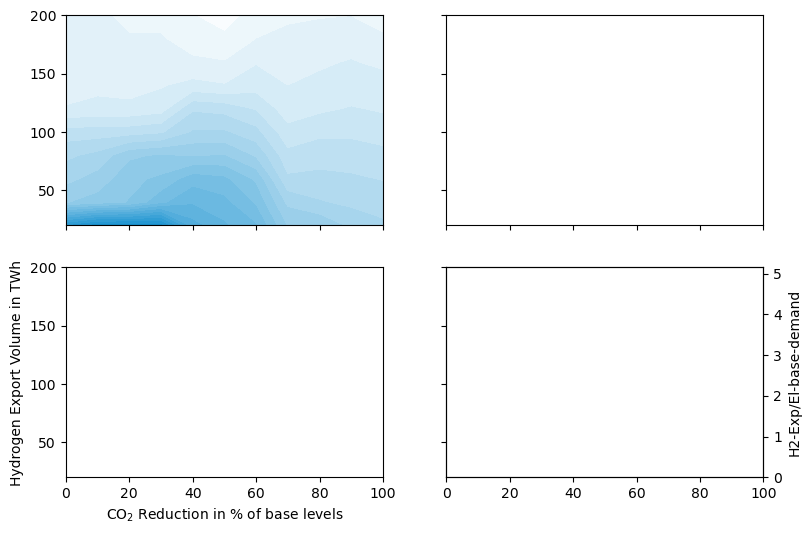

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharex=True, sharey=True)

axes[1,0].set_xlabel("CO$_2$ Reduction in % of base levels")
axes[1,0].set_ylabel("Hydrogen Export Volume in TWh")

ax2 = plt.gca().twinx()
h2export_secondary = h2export / el_base_demand
ax2.set_ylabel("H2-Exp/El-base-demand")
ax2.set_ylim(0, max(h2export_secondary))  # Adjust the limit based on your data

data_reshaped = reshape_data(data, opts, h2export, plottype=plottype)
plot_data(axes[0,0], data_reshaped, plottype, levels, cmap=my_cmap)

data_reshaped = reshape_data(data, opts, h2export, plottype="pv_p_nom_opt")
plot_data(axes[1,0], data_reshaped, plottype, levels, cmap=my_cmap)

plot_data(axes[0,1], data_reshaped, plottype, levels, cmap=my_cmap)

plot_data(axes[1,1], data_reshaped, plottype, levels, cmap=my_cmap)

plt.show()